# Import data and check features

1.   Explore
2.   Check an image
3.   Drop metadata columns
4. Convert to numpy











In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

file_path_train = '/content/drive/MyDrive/MNIST/MNIST_train.csv'
file_path_test = '/content/drive/MyDrive/MNIST/MNIST_test.csv'

df = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Features
X = df.iloc[:, 3:].to_numpy()
# Labels
y = df.iloc[:, 2].to_numpy()

# Features
X_test = df_test.iloc[:, 3:].to_numpy()
# Labels
y_test = df_test.iloc[:, 2].to_numpy()

In [34]:
df = pd.read_csv(file_path_train)
display(df.head())

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Check data types
print("Data types:")
df.info()

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum().sum())

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 787 entries, Unnamed: 0 to 783
dtypes: int64(787)
memory usage: 360.3 MB

Missing values:


np.int64(0)

In [36]:
# Select only the pixel columns (excluding 'Unnamed: 0', 'index', and 'labels')
pixel_data = df.iloc[:, 3:]

print(f"Minimum pixel value: {pixel_data.min().min()}")
print(f"Maximum pixel value: {pixel_data.max().max()}")

Minimum pixel value: 0
Maximum pixel value: 255


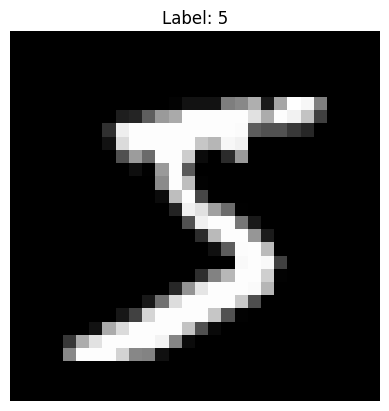

In [37]:


first_image_pixels = df.iloc[0, 3:].to_numpy()

# Reshape the pixel data into a 28x28 array
image = first_image_pixels.reshape(28, 28)

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {df.iloc[0, 2]}")
plt.axis('off')
plt.show()

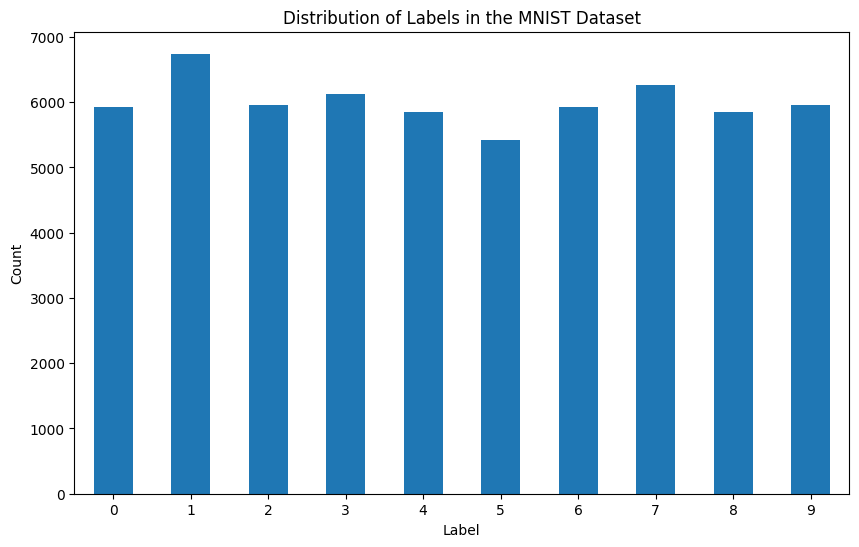

In [38]:
# Count the occurrences of each label
label_counts = df['labels'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in the MNIST Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [39]:
# Features
X = df.iloc[:, 3:].to_numpy()
# Labels
y = df.iloc[:, 2].to_numpy()


In [40]:
X.shape

(60000, 784)

In [41]:
y.shape

(60000,)

In [42]:
import numpy as np
from scipy.stats import multivariate_normal as mvn

class GaussianNB:
    """
    Gaussian Naive Bayes classifier.
    eps : Regularization term added to variances for numerical stability.
    """

    def __init__(self, eps=1e-3):
        self.eps = eps
        self.classes_ = None
        self.likelihoods_ = {}
        self.priors_ = {}

    def fit(self, X, y):

        self.classes_ = np.unique(y)

        for c in self.classes_:
            X_c = X[y == c]
            self.likelihoods_[c] = {
                "mean": X_c.mean(axis=0),
                "var": X_c.var(axis=0) + self.eps
            }
            self.priors_[c] = len(X_c) / len(X)

        return self

    def predict(self, X):

        N = X.shape[0]
        log_probs = np.zeros((N, len(self.classes_)))

        for i, c in enumerate(self.classes_):
            mean = self.likelihoods_[c]["mean"]
            var = self.likelihoods_[c]["var"]
            log_probs[:, i] = mvn.logpdf(X, mean=mean, cov=np.diag(var)) + np.log(self.priors_[c])

        return self.classes_[np.argmax(log_probs, axis=1)]

    def accuracy(self, y, y_pred):
        return np.mean(y == y_pred)


In [43]:
df_test = pd.read_csv(file_path_test)

# Features
X_test = df_test.iloc[:, 3:].to_numpy()
# Labels
y_test = df_test.iloc[:, 2].to_numpy()

# Initialize and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X, y)

# Make predictions on the test data
y_pred = gnb.predict(X_test)

# Calculate the accuracy
test_accuracy = gnb.accuracy(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.5878




###  Scaling Features to Improve Gaussian Naive Bayes (GNB) Accuracy



Gaussian Naive Bayes (GNB) models assume that each feature within a class follows a normal (Gaussian) distribution.  
When feature values differ widely in scale—as is common in image datasets like MNIST—features with larger numeric ranges can disproportionately influence the likelihood computation. This can lead to suboptimal class predictions and reduced model accuracy.

To address this issue, **Min–Max scaling** is applied to normalize each feature to a common range of [0, 1].
$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

This transformation preserves the relative distribution of pixel intensities while ensuring all features contribute equally to the model.  
By applying scaling prior to training, the GNB classifier can better estimate feature variances and class-conditional probabilities, often resulting in **higher test accuracy and more stable performance**.



In [44]:
# Create scaled versions of X and X_test
X_scaled = (X - X.min()) / (X.max() - X.min())
X_test_scaled = (X_test - X.min()) / (X.max() - X.min())

In [45]:
# Initialize and train the Gaussian Naive Bayes model with scaled data
gnb_scaled = GaussianNB()
gnb_scaled.fit(X_scaled, y)

# Make predictions on the scaled test data
y_pred_scaled = gnb_scaled.predict(X_test_scaled)

# Calculate the accuracy with scaled data
test_accuracy_scaled = gnb_scaled.accuracy(y_test, y_pred_scaled)
print(f"Test Accuracy after scaling: {test_accuracy_scaled}")

Test Accuracy after scaling: 0.7746


In [46]:
# Standardize the data
X_standardized = (X - X.mean()) / X.std()
X_test_standardized = (X_test - X_test.mean()) / X_test.std()

In [47]:
# Initialize and train the Gaussian Naive Bayes model with standardized data
gnb_standardized = GaussianNB()
gnb_standardized.fit(X_standardized, y)

# Make predictions on the standardized test data
y_pred_standardized = gnb_standardized.predict(X_test_standardized)

# Calculate the accuracy with standardized data
test_accuracy_standardized = gnb_standardized.accuracy(y_test, y_pred_standardized)
print(f"Test Accuracy after standardization: {test_accuracy_standardized}")

Test Accuracy after standardization: 0.7213


**Takeaway**
---
For Gaussian Naive Bayes:





Scaling is often better because it preserves relative variance structures
Standardization can hurt because it removes variance information that helps classification
GNB learns different variances per feature per class

## Pad images

Remove a specified number of rows and columns from the outer edges of each image. Train a Gaussian Naive Bayes model on the scaled training data after removing the outer 5 rows and columns from each image and evaluate its accuracy on the scaled test data after applying the same padding.


In [48]:
# Features
X = df.iloc[:, 3:].to_numpy()
# Labels
y = df.iloc[:, 2].to_numpy()

# Features
X_test = df_test.iloc[:, 3:].to_numpy()
# Labels
y_test = df_test.iloc[:, 2].to_numpy()

In [49]:

# Create scaled versions of X and X_test
X_scaled = (X - X.min()) / (X.max() - X.min())
X_test_scaled = (X_test - X.min()) / (X.max() - X.min())

# Reshape the scaled 1D pixel data back into 28x28 images
X_scaled_images = X_scaled.reshape(-1, 28, 28)
X_test_scaled_images = X_test_scaled.reshape(-1, 28, 28)

print(f"Shape of scaled training images: {X_scaled_images.shape}")
print(f"Shape of scaled test images: {X_test_scaled_images.shape}")

Shape of scaled training images: (60000, 28, 28)
Shape of scaled test images: (10000, 28, 28)


In [50]:
# Define the number of rows and columns to remove from each side
padding = 5

# Slice the X_scaled_images array to remove the outer rows and columns
X_scaled_padded = X_scaled_images[:, padding:-padding, padding:-padding]

# Slice the X_test_scaled_images array similarly
X_test_scaled_padded = X_test_scaled_images[:, padding:-padding, padding:-padding]

# Print the shapes of the padded training and test image arrays
print(f"Shape of padded scaled training images: {X_scaled_padded.shape}")
print(f"Shape of padded scaled test images: {X_test_scaled_padded.shape}")

Shape of padded scaled training images: (60000, 18, 18)
Shape of padded scaled test images: (10000, 18, 18)


In [51]:
# Flatten the padded 2D images back into 1D arrays
X_scaled_padded_flat = X_scaled_padded.reshape(X_scaled_padded.shape[0], -1)
X_test_scaled_padded_flat = X_test_scaled_padded.reshape(X_test_scaled_padded.shape[0], -1)

# Print the shapes of the flattened arrays
print(f"Shape of flattened padded scaled training data: {X_scaled_padded_flat.shape}")
print(f"Shape of flattened padded scaled test data: {X_test_scaled_padded_flat.shape}")

Shape of flattened padded scaled training data: (60000, 324)
Shape of flattened padded scaled test data: (10000, 324)


### Regularization Using *ε* (Epsilon) in Gaussian Naive Bayes

In Gaussian Naive Bayes, each feature’s likelihood is modeled as a Gaussian distribution with parameters (mean and variance) estimated from the training data.\
However, if a feature’s variance is extremely small or close to zero, the denominator of the Gaussian probability term becomes unstable, leading to **numerical underflow** or **overconfident predictions**.

To prevent this, a small constant **ε (epsilon)** is added to the variance term as a form of **regularization**:

$$
\sigma^2_{\text{regularized}} = \sigma^2 + \varepsilon
$$

This ensures that no feature has zero variance and stabilizes the likelihood computation across all classes.\
In this experiment, different values of ε were tested (1e-4, 1e-3, 1e-2, 1e-1) to study their impact on model performance.

Larger ε values introduce stronger smoothing, which can improve generalization on noisy data but may also blur distinctions between classes.\
The results printed below summarize how **regularization strength affects test accuracy**, helping to find an optimal trade-off between numerical stability and discriminative power.

In [52]:

# Experiment with different eps values
eps_values = [1e-4, 1e-3, 1e-2, 1e-1]
results = {}

for eps in eps_values:
    print(f"Training with eps = {eps}")
    gnb_padded = GaussianNB(eps=eps)
    gnb_padded.fit(X_scaled_padded_flat, y)
    y_pred_padded = gnb_padded.predict(X_test_scaled_padded_flat)
    test_accuracy_padded = gnb_padded.accuracy(y_test, y_pred_padded)
    results[eps] = test_accuracy_padded
    print(f"Test Accuracy with eps = {eps}: {test_accuracy_padded}")

print("\nSummary of results:")
for eps, accuracy in results.items():
    print(f"Eps = {eps}: Accuracy = {accuracy}")

Training with eps = 0.0001
Test Accuracy with eps = 0.0001: 0.8043
Training with eps = 0.001
Test Accuracy with eps = 0.001: 0.8114
Training with eps = 0.01
Test Accuracy with eps = 0.01: 0.8164
Training with eps = 0.1
Test Accuracy with eps = 0.1: 0.7793

Summary of results:
Eps = 0.0001: Accuracy = 0.8043
Eps = 0.001: Accuracy = 0.8114
Eps = 0.01: Accuracy = 0.8164
Eps = 0.1: Accuracy = 0.7793


In [53]:
import numpy as np

class LDA:
    def fit(self, X, y, eps=1e-3):
        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        # Compute means and priors
        self.means_ = {}
        self.priors_ = {}
        for c in self.classes_:
            X_c = X[y == c]
            self.means_[c] = X_c.mean(axis=0)
            self.priors_[c] = len(X_c) / len(X)

        # Compute pooled covariance
        cov = np.zeros((n_features, n_features))
        for c in self.classes_:
            X_c = X[y == c]
            diff = X_c - self.means_[c]
            cov += diff.T @ diff
        cov /= (len(X) - len(self.classes_))

        # Regularize covariance for stability
        cov += np.eye(n_features) * eps
        self.cov_inv_ = np.linalg.inv(cov)

        return self

    def predict(self, X):
        # Compute discriminant scores
        N = X.shape[0]
        scores = np.zeros((N, len(self.classes_)))

        for i, c in enumerate(self.classes_):
            mean = self.means_[c]
            prior = np.log(self.priors_[c])
            w = self.cov_inv_ @ mean
            b = -0.5 * mean.T @ w + prior
            scores[:, i] = X @ w + b

        return self.classes_[np.argmax(scores, axis=1)]

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [54]:
# Initialize and train the LDA model with padded and scaled data
lda_padded = LDA()
lda_padded.fit(X_scaled_padded_flat, y)

# Make predictions on the padded and scaled test data
y_pred_lda_padded = lda_padded.predict(X_test_scaled_padded_flat)

# Calculate the accuracy with padded and scaled data
test_accuracy_lda_padded = accuracy(y_test, y_pred_lda_padded)

# Print the accuracy
print(f"Test Accuracy with LDA after padding and scaling: {test_accuracy_lda_padded}")

Test Accuracy with LDA after padding and scaling: 0.871


In [55]:
# Experiment with different eps values for LDA
eps_values_lda = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]  # Added 1e0 as a larger regularization example
results_lda = {}

print("Experimenting with different eps values for LDA:")
for eps in eps_values_lda:
    print(f"\nTraining LDA with eps = {eps}")
    lda_padded_eps = LDA()
    lda_padded_eps.fit(X_scaled_padded_flat, y, eps=eps)
    y_pred_lda_padded_eps = lda_padded_eps.predict(X_test_scaled_padded_flat)
    test_accuracy_lda_padded_eps = accuracy(y_test, y_pred_lda_padded_eps)
    results_lda[eps] = test_accuracy_lda_padded_eps
    print(f"Test Accuracy with LDA and eps = {eps}: {test_accuracy_lda_padded_eps:.4f}")

print("\nSummary of LDA results with different eps values:")
for eps, accuracy_val in results_lda.items():
    print(f"Eps = {eps}: Accuracy = {accuracy_val:.4f}")


Experimenting with different eps values for LDA:

Training LDA with eps = 0.0001
Test Accuracy with LDA and eps = 0.0001: 0.8697

Training LDA with eps = 0.001
Test Accuracy with LDA and eps = 0.001: 0.8710

Training LDA with eps = 0.01
Test Accuracy with LDA and eps = 0.01: 0.8713

Training LDA with eps = 0.1
Test Accuracy with LDA and eps = 0.1: 0.8686

Training LDA with eps = 1.0
Test Accuracy with LDA and eps = 1.0: 0.8500

Summary of LDA results with different eps values:
Eps = 0.0001: Accuracy = 0.8697
Eps = 0.001: Accuracy = 0.8710
Eps = 0.01: Accuracy = 0.8713
Eps = 0.1: Accuracy = 0.8686
Eps = 1.0: Accuracy = 0.8500


## Pad the images




In [56]:
# Reshape the scaled 1D pixel data back into 28x28 images
X_scaled_images = X_scaled.reshape(-1, 28, 28)
X_test_scaled_images = X_test_scaled.reshape(-1, 28, 28)

# Define the number of rows and columns to remove from each side
padding = 5

# Slice the X_scaled_images array to remove the outer rows and columns
X_scaled_padded = X_scaled_images[:, padding:-padding, padding:-padding]

# Slice the X_test_scaled_images array similarly
X_test_scaled_padded = X_test_scaled_images[:, padding:-padding, padding:-padding]

# Print the shapes of the padded training and test image arrays
print(f"Shape of padded scaled training images: {X_scaled_padded.shape}")
print(f"Shape of padded scaled test images: {X_test_scaled_padded.shape}")

Shape of padded scaled training images: (60000, 18, 18)
Shape of padded scaled test images: (10000, 18, 18)


In [57]:
# Flatten the padded 2D images back into 1D arrays
X_scaled_padded_flat = X_scaled_padded.reshape(X_scaled_padded.shape[0], -1)
X_test_scaled_padded_flat = X_test_scaled_padded.reshape(X_test_scaled_padded.shape[0], -1)

# Print the shapes of the flattened arrays
print(f"Shape of flattened padded scaled training data: {X_scaled_padded_flat.shape}")
print(f"Shape of flattened padded scaled test data: {X_test_scaled_padded_flat.shape}")

Shape of flattened padded scaled training data: (60000, 324)
Shape of flattened padded scaled test data: (10000, 324)


## Train and evaluate the QDA model



In [58]:
from scipy.stats import multivariate_normal as mvn
import numpy as np

class QDA:
    def fit(self, X, y, eps=0.01):
        self.classes = np.unique(y)
        self.models = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.models[c] = {
                "mean": X_c.mean(axis=0),
                "cov": np.cov(X_c.T) + np.eye(X.shape[1]) * eps # Add regularization
            }
            self.priors[c] = len(X_c) / len(X)

    def predict(self, X):
        N = X.shape[0]
        K = len(self.classes)
        P = np.zeros((N, K))

        for i, c in enumerate(self.classes):
            mean = self.models[c]["mean"]
            cov = self.models[c]["cov"]
            try:
                P[:, i] = mvn.logpdf(X, mean=mean, cov=cov) + np.log(self.priors[c])
            except np.linalg.LinAlgError:
                print(f"Skipping class {c} due to singular covariance matrix.")
                P[:, i] = -np.inf # Assign a very low probability


        return self.classes[np.argmax(P, axis=1)]

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

# Initialize the QDA model
qda_padded = QDA()

# Fit the QDA model using the padded and scaled training data
qda_padded.fit(X_scaled_padded_flat, y)

# Make predictions on the padded and scaled test data
y_pred_qda_padded = qda_padded.predict(X_test_scaled_padded_flat)

# Calculate the accuracy with padded and scaled data
test_accuracy_qda_padded = accuracy(y_test, y_pred_qda_padded)

# Print the accuracy
print(f"Test Accuracy with QDA after padding and scaling: {test_accuracy_qda_padded}")

Test Accuracy with QDA after padding and scaling: 0.9552


## Per-Digit Accuracy Analysis and Confusion Matrices

Overall accuracy can be misleading when dealing with multi-class classification problems. To gain a deeper understanding of how each model performs on individual digits, we will generate confusion matrices for the trained GNB, LDA, and QDA models. A confusion matrix provides a detailed breakdown of correct and incorrect predictions for each class, allowing us to identify which digits are being misclassified and how.

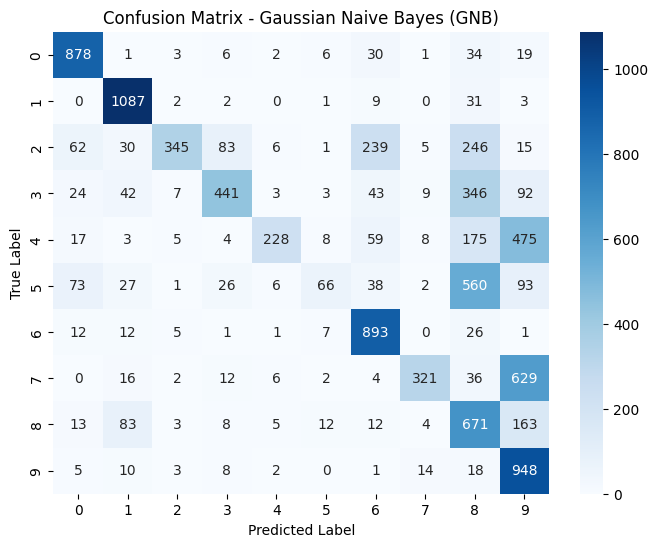

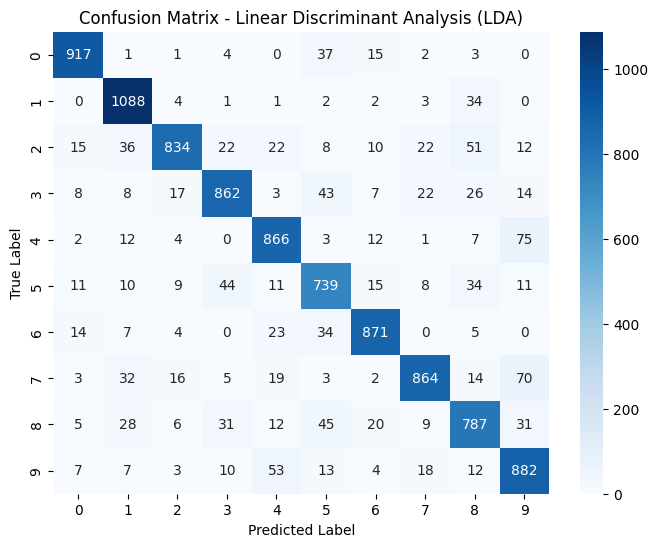

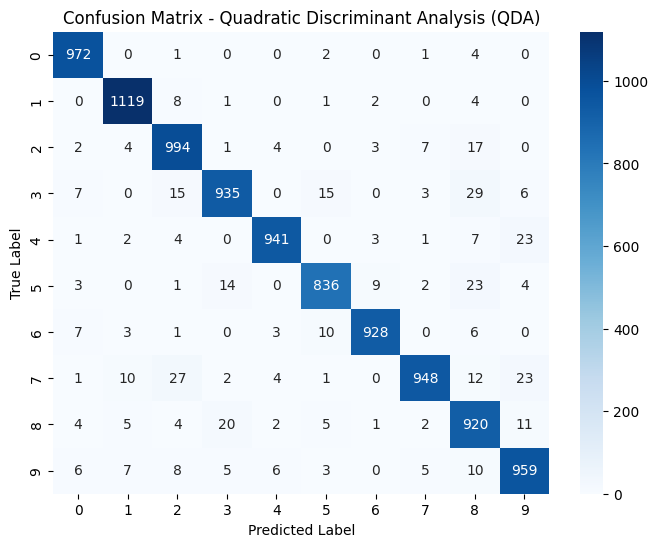

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate confusion matrix from scratch
def confusion_matrix(y_true, y_pred, classes):
    """
        Args:
        y_true (array): True labels.
        y_pred (array): Predicted labels.
        classes (list): List of unique class labels.

        Returns: The confusion matrix.
    """
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    class_to_index = {c: i for i, c in enumerate(classes)}

    for true_label, pred_label in zip(y_true, y_pred):
        true_index = class_to_index[true_label]
        pred_index = class_to_index[pred_label]
        cm[true_index, pred_index] += 1

    return cm


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, classes):
    cm = confusion_matrix(y_true, y_pred, classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get the unique classes from the training labels
classes = sorted(np.unique(y))


# Confusion Matrix for Gaussian Naive Bayes (GNB)
plot_confusion_matrix(y_test, y_pred, "Gaussian Naive Bayes (GNB)", classes)

# Confusion Matrix for Linear Discriminant Analysis (LDA)
plot_confusion_matrix(y_test, y_pred_lda_padded, "Linear Discriminant Analysis (LDA)", classes)

# Confusion Matrix for Quadratic Discriminant Analysis (QDA)
plot_confusion_matrix(y_test, y_pred_qda_padded, "Quadratic Discriminant Analysis (QDA)", classes)

In [76]:
# Calculate per-class statistics and overall accuracy for LDA and QDA
def per_class_stats(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, classes)

    # Per-class accuracy (correct / total for that true class)
    per_class_acc = np.zeros(len(classes))
    for i in range(len(classes)):
        true_positives = cm[i, i]
        total_true = cm[i, :].sum()
        if total_true > 0:
            per_class_acc[i] = true_positives / total_true
        else:
            per_class_acc[i] = np.nan

    # Precision, Recall, F1 Score
    precision = np.zeros(len(classes))
    recall = np.zeros(len(classes))
    f1 = np.zeros(len(classes))

    for i in range(len(classes)):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives

        # Precision: TP / (TP + FP)
        if (true_positives + false_positives) > 0:
            precision[i] = true_positives / (true_positives + false_positives)
        else:
            precision[i] = 0

        # Recall: TP / (TP + FN)
        if (true_positives + false_negatives) > 0:
            recall[i] = true_positives / (true_positives + false_negatives)
        else:
            recall[i] = 0

        # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
        if (precision[i] + recall[i]) > 0:
            f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f1[i] = 0

    return {
        "confusion_matrix": cm,
        "accuracy": per_class_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Get the unique classes from the training labels (assuming y is available)
classes = sorted(np.unique(y))

# Calculate stats for LDA
stats_lda = per_class_stats(y_test, y_pred_lda_padded, classes)

# Calculate stats for QDA
stats_qda = per_class_stats(y_test, y_pred_qda_padded, classes)

# Calculate overall accuracy for LDA and QDA using the defined accuracy function
overall_acc_lda = accuracy(y_test, y_pred_lda_padded)
overall_acc_qda = accuracy(y_test, y_pred_qda_padded)

print("Overall LDA accuracy (manual):", overall_acc_lda)
print("Overall QDA accuracy (manual):", overall_acc_qda)

print("\nPer-class statistics for LDA (manual):")
for i, c in enumerate(classes):
    print(f"Class {c}: Accuracy={stats_lda['accuracy'][i]:.4f}, Precision={stats_lda['precision'][i]:.4f}, Recall={stats_lda['recall'][i]:.4f}, F1={stats_lda['f1'][i]:.4f}")

print("\nPer-class statistics for QDA (manual):")
for i, c in enumerate(classes):
    print(f"Class {c}: Accuracy={stats_qda['accuracy'][i]:.4f}, Precision={stats_qda['precision'][i]:.4f}, Recall={stats_qda['recall'][i]:.4f}, F1={stats_qda['f1'][i]:.4f}")

Overall LDA accuracy (manual): 0.871
Overall QDA accuracy (manual): 0.9552

Per-class statistics for LDA (manual):
Class 0: Accuracy=0.9357, Precision=0.9338, Recall=0.9357, F1=0.9348
Class 1: Accuracy=0.9586, Precision=0.8853, Recall=0.9586, F1=0.9205
Class 2: Accuracy=0.8081, Precision=0.9287, Recall=0.8081, F1=0.8642
Class 3: Accuracy=0.8535, Precision=0.8805, Recall=0.8535, F1=0.8668
Class 4: Accuracy=0.8819, Precision=0.8574, Recall=0.8819, F1=0.8695
Class 5: Accuracy=0.8285, Precision=0.7972, Recall=0.8285, F1=0.8125
Class 6: Accuracy=0.9092, Precision=0.9092, Recall=0.9092, F1=0.9092
Class 7: Accuracy=0.8405, Precision=0.9104, Recall=0.8405, F1=0.8741
Class 8: Accuracy=0.8080, Precision=0.8088, Recall=0.8080, F1=0.8084
Class 9: Accuracy=0.8741, Precision=0.8055, Recall=0.8741, F1=0.8384

Per-class statistics for QDA (manual):
Class 0: Accuracy=0.9918, Precision=0.9691, Recall=0.9918, F1=0.9803
Class 1: Accuracy=0.9859, Precision=0.9730, Recall=0.9859, F1=0.9794
Class 2: Accuracy

In [77]:
# Calculate per-class statistics for GNB using the manual function
stats_gnb = per_class_stats(y_test, y_pred, classes)

# Create a DataFrame for plotting with GNB, LDA, and QDA stats
df_metrics = pd.DataFrame({
    "digit": np.tile(classes, 3),
    "model": np.repeat(["GNB", "LDA", "QDA"], len(classes)),
    "accuracy": np.concatenate([stats_gnb["accuracy"], stats_lda["accuracy"], stats_qda["accuracy"]]),
    "precision": np.concatenate([stats_gnb["precision"], stats_lda["precision"], stats_qda["precision"]]),
    "recall": np.concatenate([stats_gnb["recall"], stats_lda["recall"], stats_qda["recall"]]),
    "f1": np.concatenate([stats_gnb["f1"], stats_lda["f1"], stats_qda["f1"]]),
})

display(df_metrics)

,digit,model,accuracy,precision,recall,f1
0,0,GNB,0.895918,0.809963,0.895918,0.850775
1,1,GNB,0.957709,0.829138,0.957709,0.888798
2,2,GNB,0.334302,0.917553,0.334302,0.490057
3,3,GNB,0.436634,0.746193,0.436634,0.550906
4,4,GNB,0.232179,0.880309,0.232179,0.367446
5,5,GNB,0.073991,0.622642,0.073991,0.132265
6,6,GNB,0.932150,0.672440,0.932150,0.781277
7,7,GNB,0.312257,0.881868,0.312257,0.461207
8,8,GNB,0.688912,0.313112,0.688912,0.430542
9,9,GNB,0.939544,0.388843,0.939544,0.550044


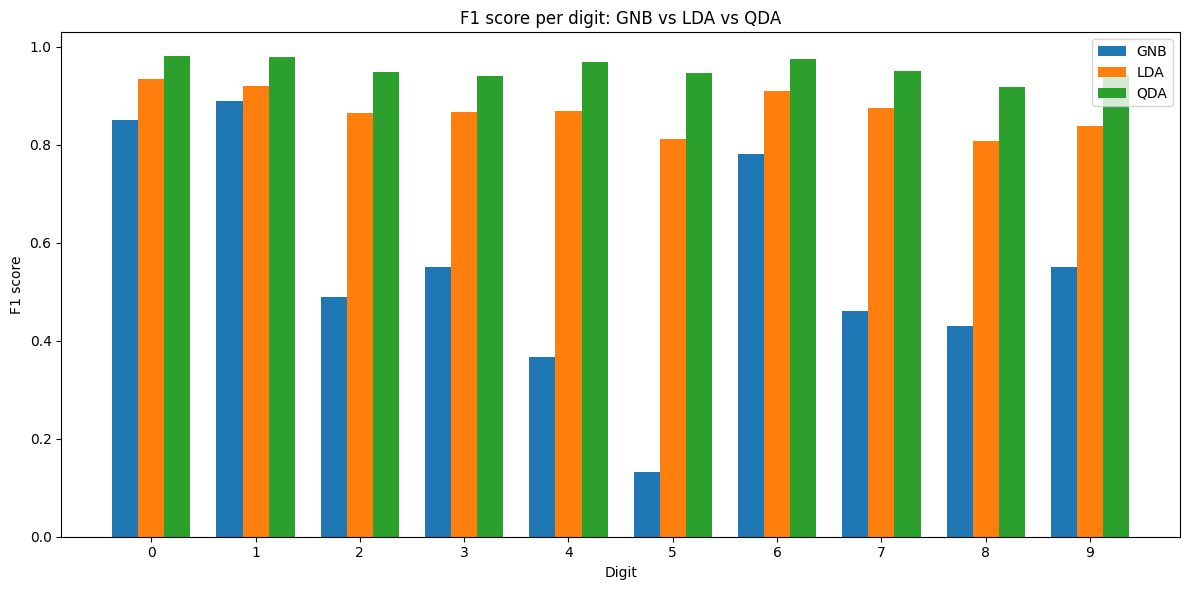

In [71]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(classes))  # 0..9
width = 0.25

f1_gnb = stats_gnb["f1"]
f1_lda = stats_lda["f1"]
f1_qda = stats_qda["f1"]

plt.figure(figsize=(12, 6))
plt.bar(x - width, f1_gnb, width, label="GNB")
plt.bar(x, f1_lda, width, label="LDA")
plt.bar(x + width, f1_qda, width, label="QDA")

plt.xticks(x, classes)
plt.xlabel("Digit")
plt.ylabel("F1 score")
plt.title("F1 score per digit: GNB vs LDA vs QDA")
plt.legend()
plt.tight_layout()
plt.show()

## Generate per-digit bar charts





Generate and display the bar charts for accuracy, precision, and recall per digit for each model based on the calculated metrics in df_metrics_manual.



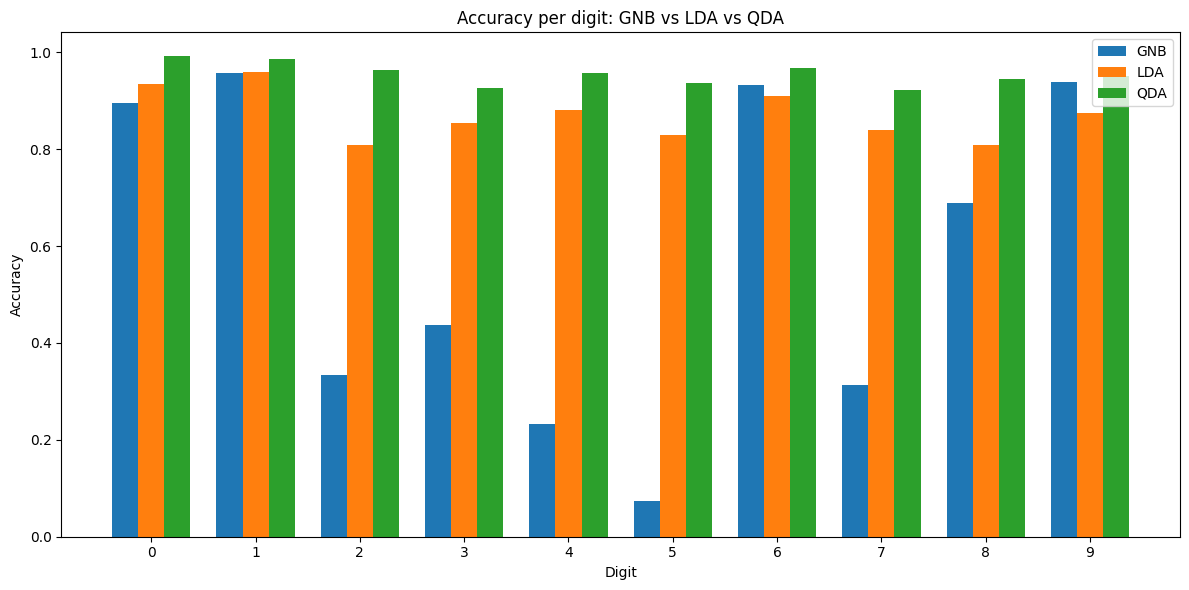

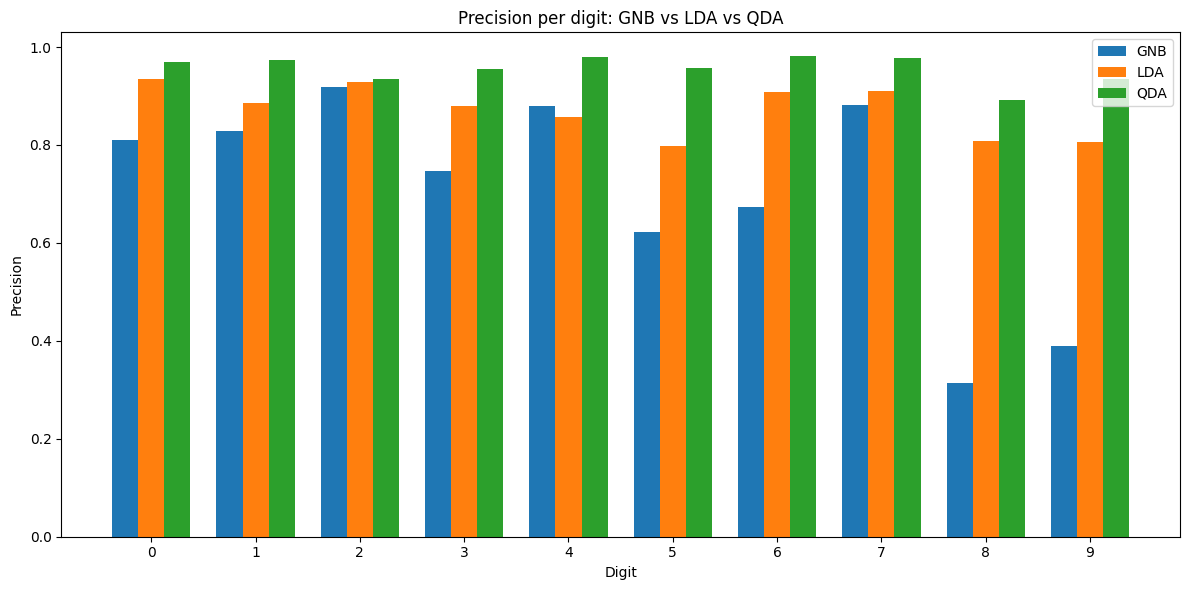

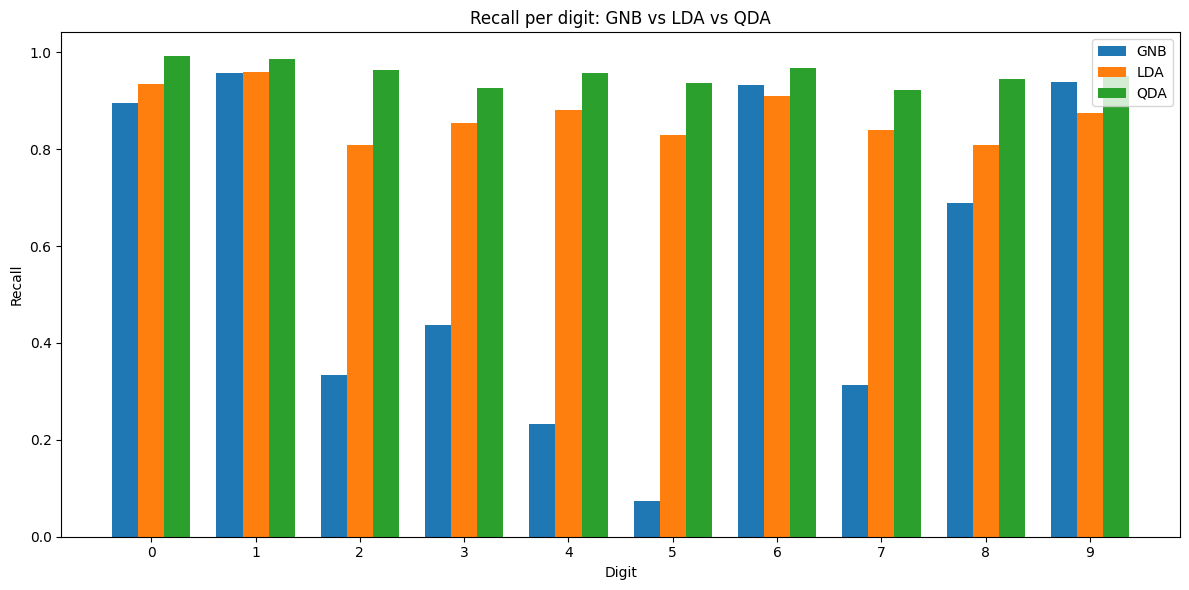

In [78]:

# Extract metrics for each model from the DataFrame
accuracy_gnb = df_metrics[df_metrics['model'] == 'GNB']['accuracy']
accuracy_lda = df_metrics[df_metrics['model'] == 'LDA']['accuracy']
accuracy_qda = df_metrics[df_metrics['model'] == 'QDA']['accuracy']

precision_gnb = df_metrics[df_metrics['model'] == 'GNB']['precision']
precision_lda = df_metrics[df_metrics['model'] == 'LDA']['precision']
precision_qda = df_metrics[df_metrics['model'] == 'QDA']['precision']

recall_gnb = df_metrics[df_metrics['model'] == 'GNB']['recall']
recall_lda = df_metrics[df_metrics['model'] == 'LDA']['recall']
recall_qda = df_metrics[df_metrics['model'] == 'QDA']['recall']

x = np.arange(len(classes))  # 0..9
width = 0.25

# Plot Accuracy per digit
plt.figure(figsize=(12, 6))
plt.bar(x - width, accuracy_gnb, width, label="GNB")
plt.bar(x, accuracy_lda, width, label="LDA")
plt.bar(x + width, accuracy_qda, width, label="QDA")
plt.xticks(x, classes)
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Accuracy per digit: GNB vs LDA vs QDA")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Precision per digit
plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_gnb, width, label="GNB")
plt.bar(x, precision_lda, width, label="LDA")
plt.bar(x + width, precision_qda, width, label="QDA")
plt.xticks(x, classes)
plt.xlabel("Digit")
plt.ylabel("Precision")
plt.title("Precision per digit: GNB vs LDA vs QDA")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Recall per digit
plt.figure(figsize=(12, 6))
plt.bar(x - width, recall_gnb, width, label="GNB")
plt.bar(x, recall_lda, width, label="LDA")
plt.bar(x + width, recall_qda, width, label="QDA")
plt.xticks(x, classes)
plt.xlabel("Digit")
plt.ylabel("Recall")
plt.title("Recall per digit: GNB vs LDA vs QDA")
plt.legend()
plt.tight_layout()
plt.show()

## Create overall metrics table





Calculate the macro-averaged metrics and create a DataFrame to display the overall performance of each model.



In [74]:
# Calculate macro-averaged metrics
macro_precision_gnb = np.mean(stats_gnb["precision"])
macro_recall_gnb = np.mean(stats_gnb["recall"])
macro_f1_gnb = np.mean(stats_gnb["f1"])

macro_precision_lda = np.mean(stats_lda["precision"])
macro_recall_lda = np.mean(stats_lda["recall"])
macro_f1_lda = np.mean(stats_lda["f1"])

macro_precision_qda = np.mean(stats_qda["precision"])
macro_recall_qda = np.mean(stats_qda["recall"])
macro_f1_qda = np.mean(stats_qda["f1"])

# Calculate overall accuracy for GNB
overall_acc_gnb = accuracy(y_test, y_pred)


# Create a DataFrame for overall metrics
overall_metrics_df = pd.DataFrame({
    'Model': ['GNB', 'LDA', 'QDA'],
    'Overall Accuracy': [overall_acc_gnb, overall_acc_lda, overall_acc_qda],
    'Macro Precision': [macro_precision_gnb, macro_precision_lda, macro_precision_qda],
    'Macro Recall': [macro_recall_gnb, macro_recall_lda, macro_recall_qda],
    'Macro F1': [macro_f1_gnb, macro_f1_lda, macro_f1_qda]
})

# Display the DataFrame
display(overall_metrics_df)

,Model,Overall Accuracy,Macro Precision,Macro Recall,Macro F1
0,GNB,0.5878,0.706206,0.580360,0.550332
1,LDA,0.8710,0.871686,0.869805,0.869833
2,QDA,0.9552,0.955656,0.954800,0.954972
